# Weather prediction using ARIMA model

Below are the major steps that have been carried out : 
* **Feature Engineering**
* **Data Cleaning**
* **Exploratory Data Analysis & Visualizations**
* **Time series Prediction**

## <a>Import required libraries</a>

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

import seaborn as sns # for plot visualization
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# import os
# print(os.listdir("../input"))

There is column named **datetime_utc** in this dataset, we are going to read that as an index.

In [4]:
weather_df = pd.read_csv('testset1.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
datetime_utc,,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24,0,0,2.0,0.0,North,NaN,NaN,NaN
1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23,0,0,1.2,0.0,North,NaN,NaN,0.0
1996-11-01 17:00:00,Smoke,12.0,0,0,NaN,56.0,NaN,1011.0,0,0,21,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 18:00:00,Smoke,13.0,0,0,NaN,60.0,NaN,1010.0,0,0,21,0,0,0.8,0.0,North,NaN,NaN,0.0


## <a>Feature Engineering</a>

Here we are going to consider only few of the columns which seems important from some basic EDA and time series prediction's point of view. At the same time renaming with some better ones.

In [5]:
weather_df = weather_df.loc[:,[' _conds', ' _hum', ' _tempm']]
weather_df = weather_df.rename(index=str, columns={' _conds': 'condition', ' _hum': 'humidity', ' _pressurem': 'pressure', ' _tempm': 'temprature'})
print(f'dataset shape (rows, columns) - {weather_df.shape}')
weather_df.head()

dataset shape (rows, columns) - (99153, 3)


,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30
1996-11-01 14:00:00,Smoke,41.0,24
1996-11-01 16:00:00,Smoke,47.0,23
1996-11-01 17:00:00,Smoke,56.0,21
1996-11-01 18:00:00,Smoke,60.0,21


In [6]:
# lets check dtype of all columns, 
weather_df.dtypes, weather_df.index.dtype

(condition      object
 humidity      float64
 temprature      int64
 dtype: object, dtype('O'))

It shows 'index' as object type which needs to be converted to datetime otherwise we won't be able to perform scaling during time series analysis.

In [7]:
weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 21:00:00',
               '1996-11-01 22:00:00', '1996-11-01 23:00:00',
               '1996-11-02 00:00:00', '1996-11-02 01:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=99153, freq=None)

Seems fine. Now lets check the total number (and percent) of missing values in each columns.

## <a>Data Cleaning</a>

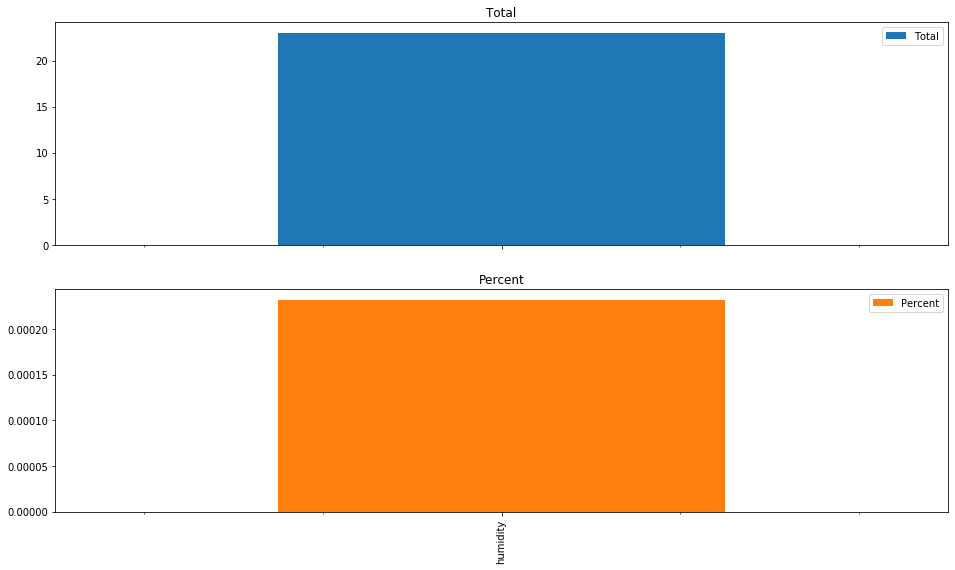

In [8]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    
    missing_data.plot.bar(subplots=True, figsize=(16,9))

list_and_visualize_missing_data(weather_df)

Not many values are missing, but it will still be great to fill the missing ones instead of removing entire row.

In [9]:
# will fill with previous valid value
weather_df.ffill(inplace=True)
weather_df[weather_df.isnull()].count()

condition     0
humidity      0
temprature    0
dtype: int64

In [10]:
weather_df.describe()

,humidity,temprature
count,99153.000000,99153.000000
mean,57.931470,25.436406
std,23.777664,8.470813
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,243.000000,90.000000


In [11]:
weather_df.head()

,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30
1996-11-01 14:00:00,Smoke,41.0,24
1996-11-01 16:00:00,Smoke,47.0,23
1996-11-01 17:00:00,Smoke,56.0,21
1996-11-01 18:00:00,Smoke,60.0,21


It is showing maximum temprature as 90 and max humidity as 243 which is non-realistic, so is an outlier. We need to treat these outliers.

In [12]:
weather_df = weather_df[weather_df.temprature < 50]
weather_df = weather_df[weather_df.humidity <= 100]

In [13]:
weather_df.describe()

,humidity,temprature
count,99146.000000,99146.000000
mean,57.929316,25.434511
std,23.761586,8.465657
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,100.000000,47.000000


In [14]:
weather_df.head()

,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30
1996-11-01 14:00:00,Smoke,41.0,24
1996-11-01 16:00:00,Smoke,47.0,23
1996-11-01 17:00:00,Smoke,56.0,21
1996-11-01 18:00:00,Smoke,60.0,21


## <a>Exploratory Data Analysis & Visualizations</a>

Let's checkout the most common weather condition type in Delhi.

Text(0, 0.5, 'Percent')

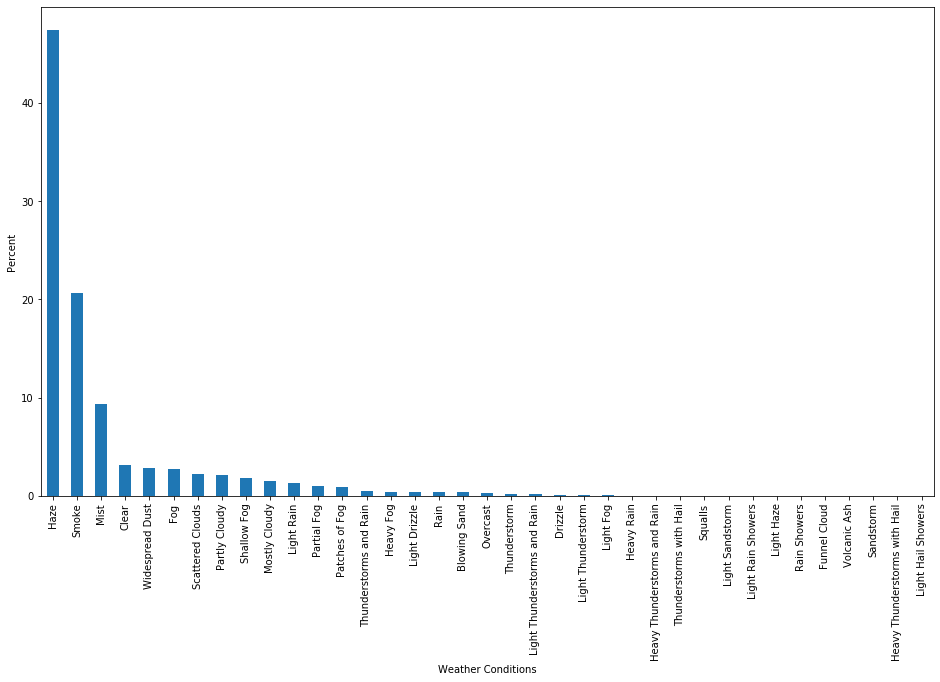

In [15]:
weather_condition = (weather_df.condition.value_counts()/(weather_df.condition.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')

Oh, it is really bad that mostly Delhi has Hazy and smoky weather conditions, it shows the level of pollution city has.

Let's see how plot for all year's temprature and humidity looks like.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001697E492748>,
      dtype=object)

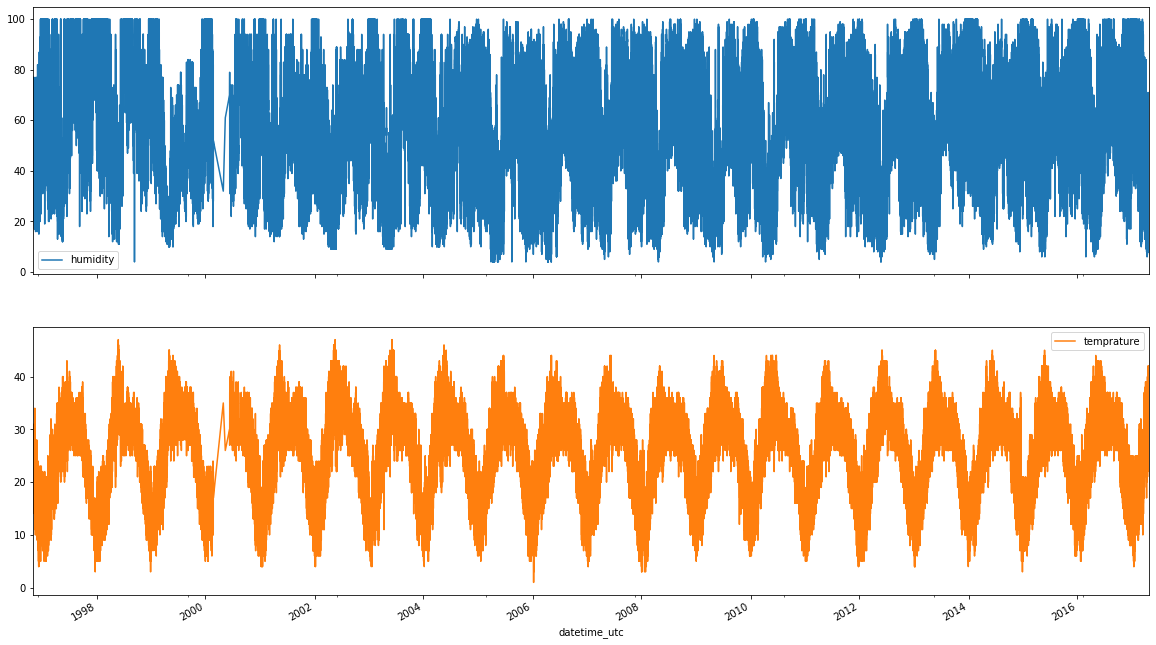

In [16]:
weather_df.plot(subplots=True, figsize=(20,12))

It seems overplotted, let's plot for only two years 2015 and 2016, it will give us the clear picture of seasonality and tread.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001697E52F6C8>,
      dtype=object)

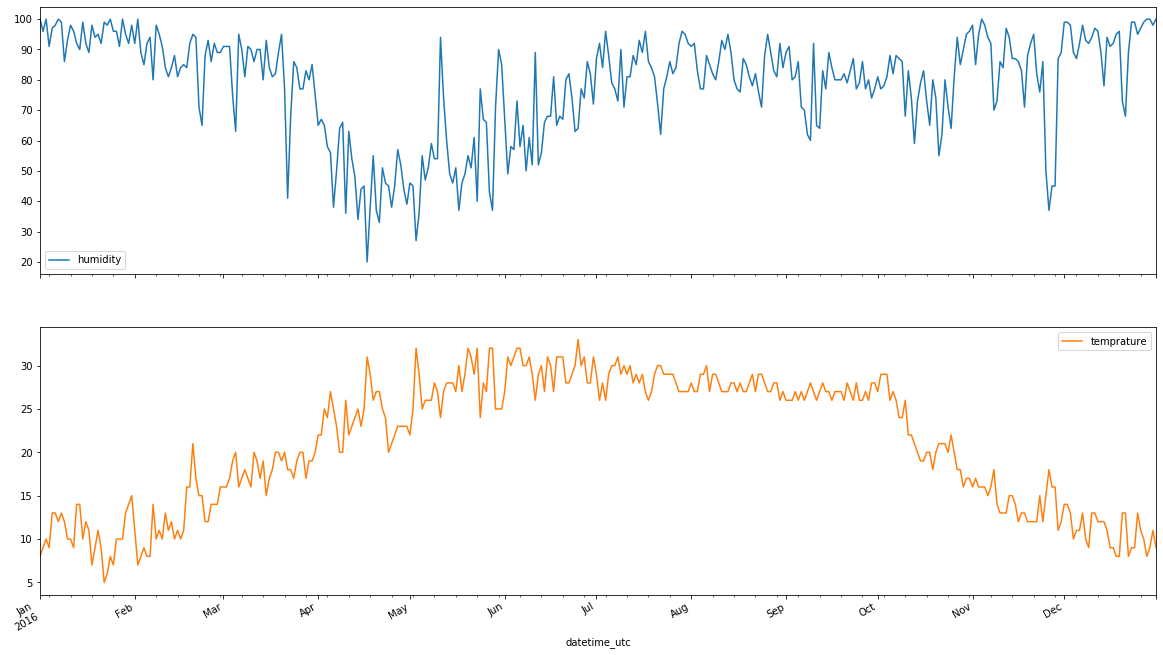

In [17]:
weather_df['2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

So it shows that mid two quarter are hotter than first and last, humidity varies accordingly.

In [18]:
train_df = weather_df['1996':'2015'].resample('D').mean().fillna(method='pad')
train_df.drop(columns='humidity', axis=1, inplace=True)
test_df = weather_df['2016':'2017'].resample('D').mean().fillna(method='pad')
test_df.drop(columns='humidity', axis=1, inplace=True)

In [19]:
test_df

,temprature
datetime_utc,
2016-01-01,14.714286
2016-01-02,14.000000
2016-01-03,14.375000
2016-01-04,15.750000
2016-01-05,15.833333
...,...
2017-04-20,34.500000
2017-04-21,34.250000
2017-04-22,32.333333


### Check Stationarity
So above plots shows that we do have seasonality but there is no trend. Let's check for below necessary conditions:

* Constant mean
* Constant variance
* An auto co-variance that does not depend on time

In [20]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [21]:
# Augmented Dickey–Fuller test
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

In Dickey-Fuller test, we need only test_statics and critical_value to know if it is stationary or not

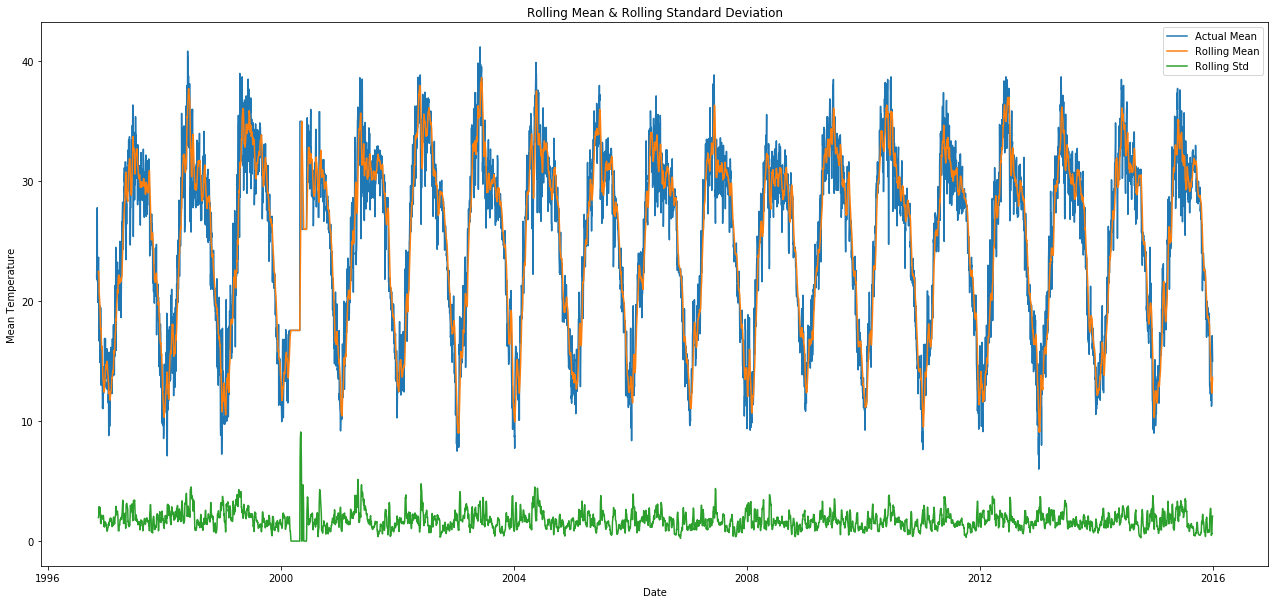

Test statistic:  -6.6049014560811115
Critical Values: {'1%': -3.431289361291529, '5%': -2.8619551218853436, '10%': -2.566990965445166}


In [22]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train_df.temprature)
perform_dickey_fuller_test(train_df.temprature)

We have constant Mean and Variance, and our Test statistic is less than Critical Values, so we already have stationary Time series. So our 'd' value will become 0 in ARIMA Model.

Consider a case if it was non-stationary, in that case we would use below techniques to make it stationary

Make Stationary
For non-stationary to stationary conversion, we can use any of the below technique :

- Decomposing
- Differencing

Here, we are preferring Differencing because it is very straight forward. We would use below co-relation plots to identify the order of differencing

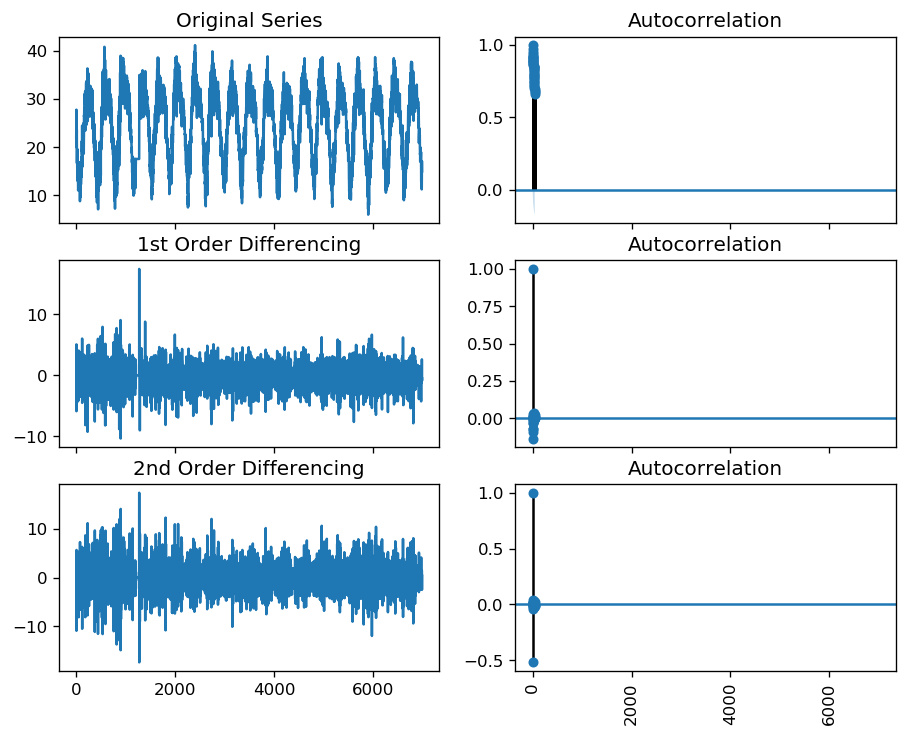

In [23]:
# Original Series
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_df.values); 
axes[0, 0].set_title('Original Series')
plot_acf(train_df.values, ax=axes[0, 1])

# 1st Differencing`
axes[1, 0].plot(train_df.temprature.diff().values); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_df.diff().dropna().values,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_df.temprature.diff().diff().values); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_df.diff().diff().dropna().values,ax=axes[2, 1])

plt.xticks(rotation='vertical')
plt.show()

As you can see here the first series itself is perfectly stationary, So we don't need any differencing here

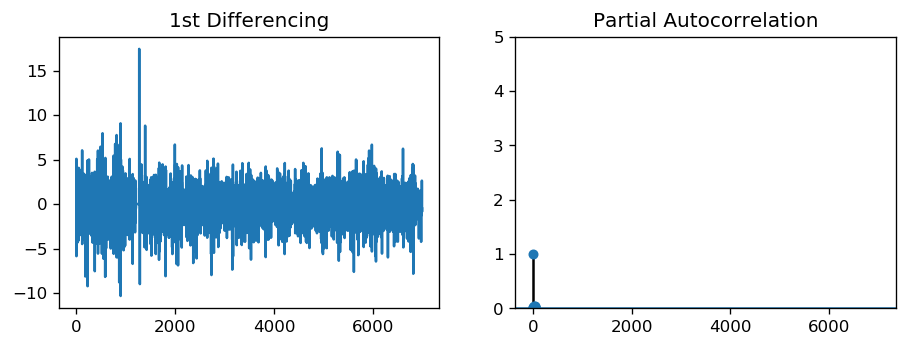

In [24]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

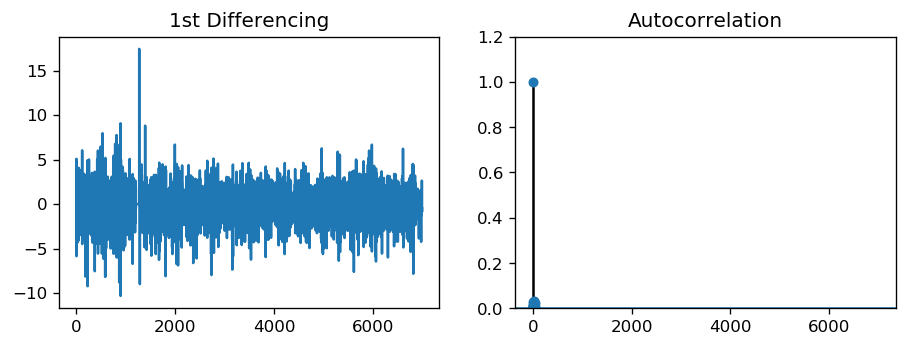

In [25]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

### Timeseries Analysis (ARIMA Model)

For prediction we are going to use one of the most popular model for time series, **Autoregressive Integrated Moving Average (ARIMA)** which is a standard statistical model for time series forecast and analysis.
An ARIMA model can be understood by outlining each of its components as follows:
* **Autoregression (AR) -** refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.<br/>
The notation **AR(p)** indicates an autoregressive model of order p.

    *Example* — If p is 3 the predictor for X(t) will be 
        X(t) = µ + X(t-1) + X(t-2) + X(t-3) + εt

    Where ε is error term.
* **Integrated (I) -** represents the differencing of raw observations to allow for the time series to become stationary, i.e., data values are replaced by the difference between the data values and the previous values.
* **Moving average (MA) -** incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

    The notation **MA(q)** refers to the moving average model of order q:<br/>
 ![image.png](attachment:image.png)

    *Example* — If q is 3 the predictor for X(t) will be 
        X(t) = µ + εt + θ1.ε(t-1) + θ2.ε(t-2) + θ3.ε(t-3)
    Here instead of difference from previous term, we take errer term (ε) obtained from the difference from past term
Now we need to figure out the values of p and q which are parameters of ARIMA model. We use below two methods to figure out these values  -

**Autocorrelation Function (ACF):** It just measures the correlation between two consecutive (lagged version). example at lag 4, ACF will compare series at time instance t1…t2 with series at instance t1–4…t2–4

**Partial Autocorrelation Function (PACF):** is used to measure the degree of association between X(t) and X(t-p).

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


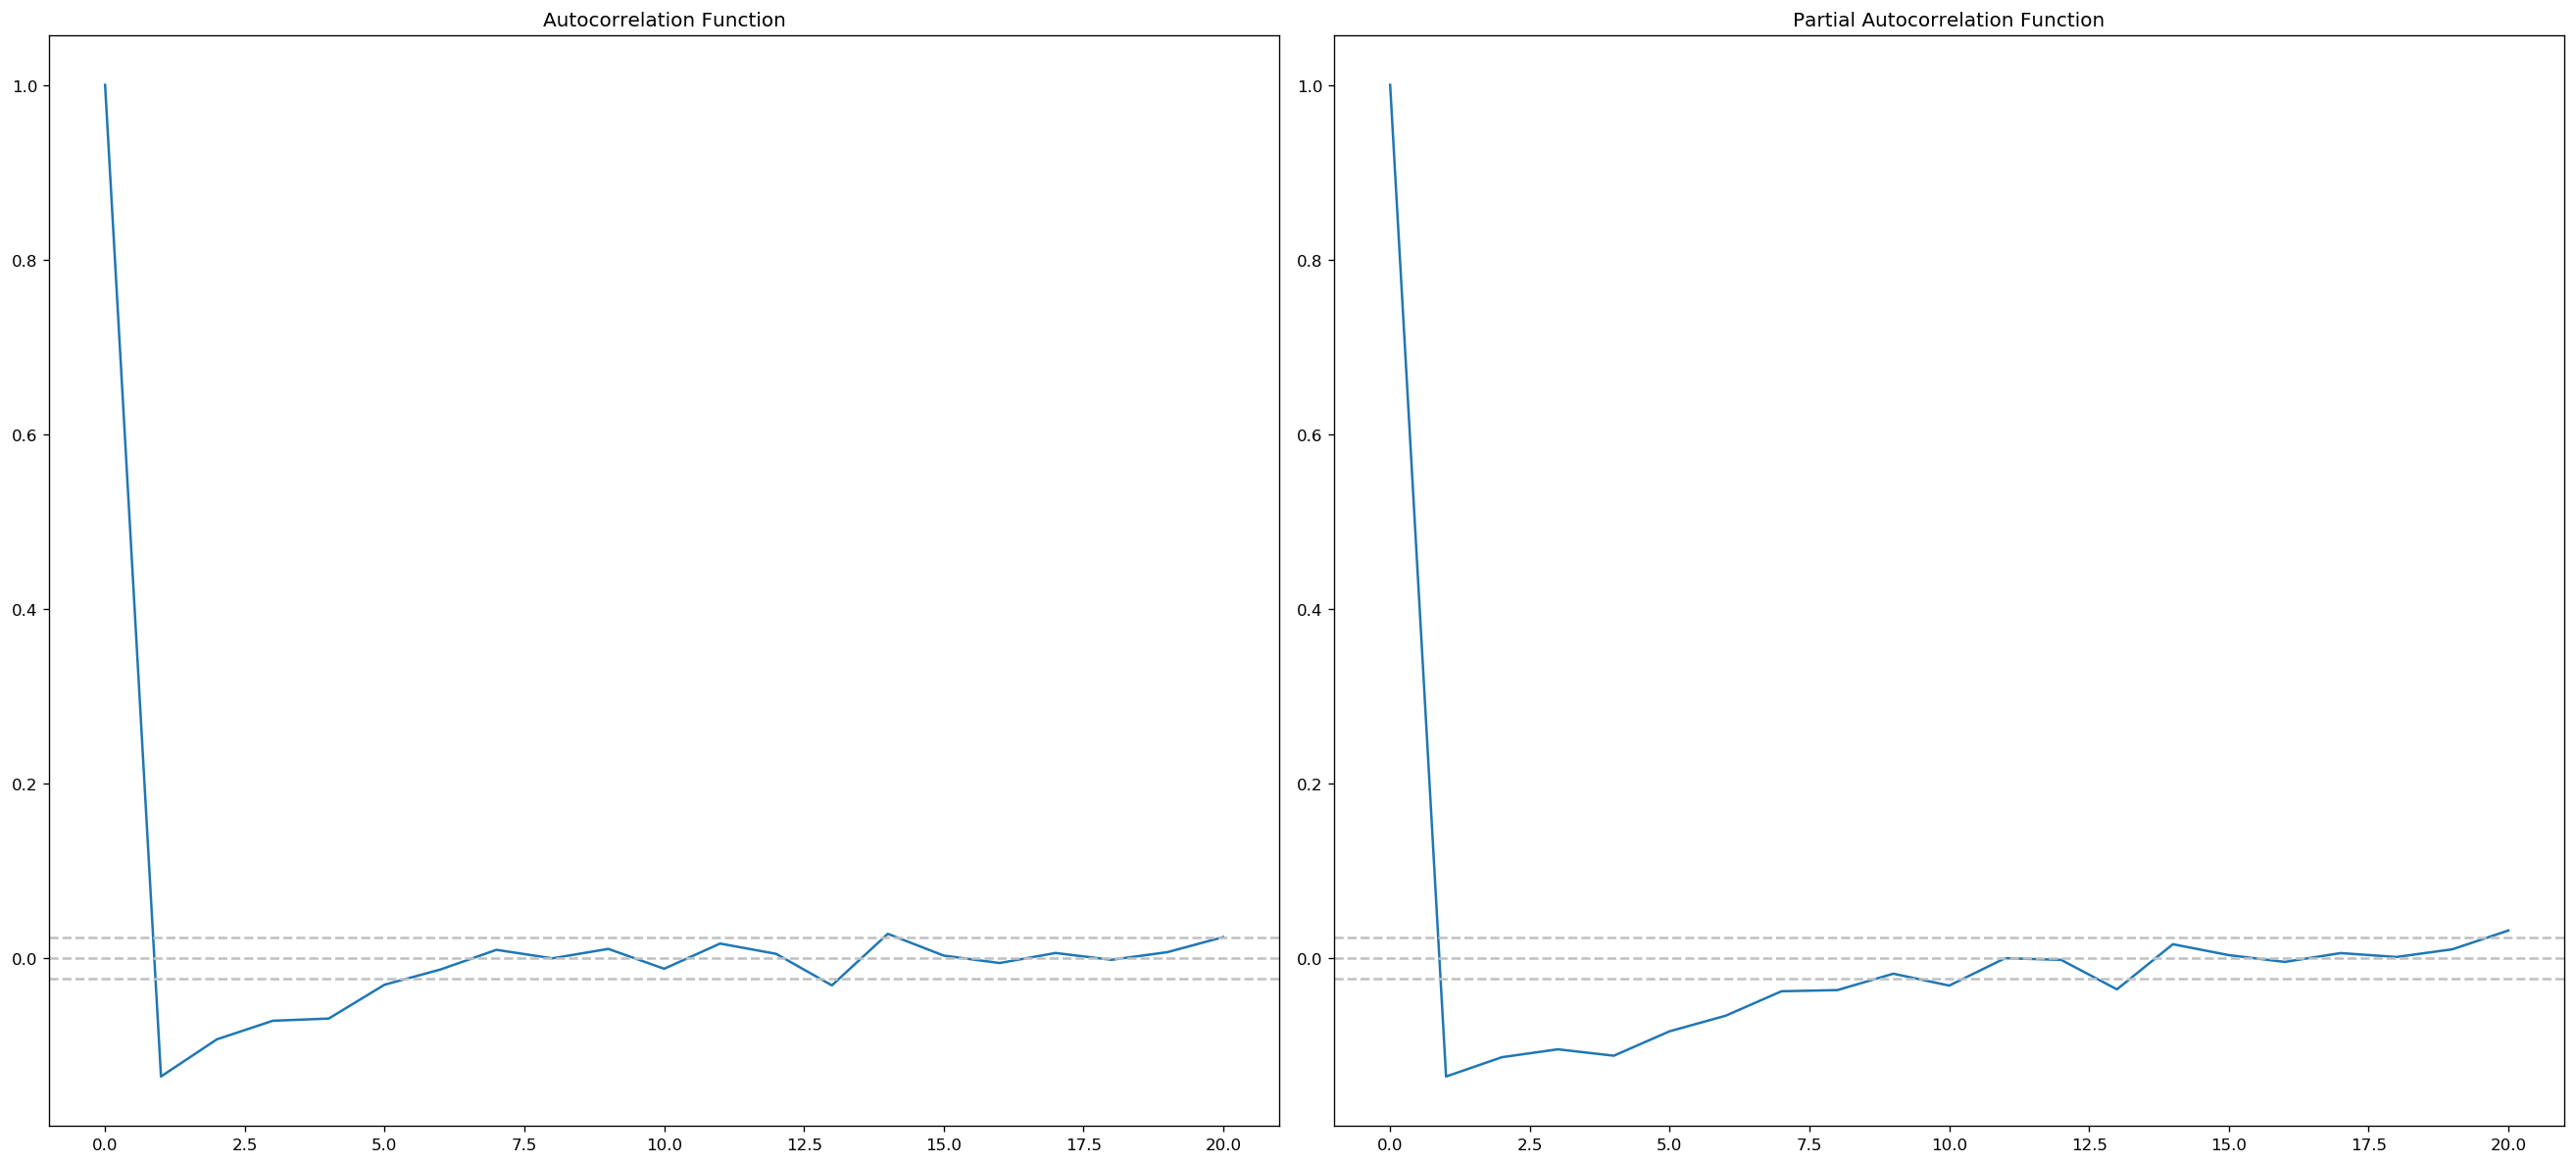

In [26]:
acf_lag = acf(train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

These grey dotted line are confidence intervels which we are going to use to find out the value of p and q.

__p__ - *the point where PACF crosses the upper confiednce level. In our case it seems to be 2. So we will take *p = 2.

__q__ - the point where ACF crosses the upper confiednce level. In our case it seems to be 2. So we will take q = 2.

__d__ - number of nonseasonal differences needed for stationarity. In this case we are going to take it as 0, since this series is already stationary.

Now we are going fit time series for ARIMA Models. We will compare performance on the basis of RSS score and at last prefer the best one.

In [27]:
model = ARIMA(train_df.values, order=(5,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 7000
Model:                     ARMA(5, 3)   Log Likelihood              -13387.173
Method:                       css-mle   S.D. of innovations              1.637
Date:                Thu, 05 Dec 2019   AIC                          26794.346
Time:                        19:57:39   BIC                          26862.882
Sample:                             0   HQIC                         26817.962
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.7447      0.251     98.609      0.000      24.253      25.237
ar.L1.y        1.6871        nan        nan        nan         nan         nan
ar.L2.y        0.2654      0.001    489.146      0.0

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [28]:
train_df.head()

,temprature
datetime_utc,
1996-11-01,22.000000
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000


In [29]:
model_fit

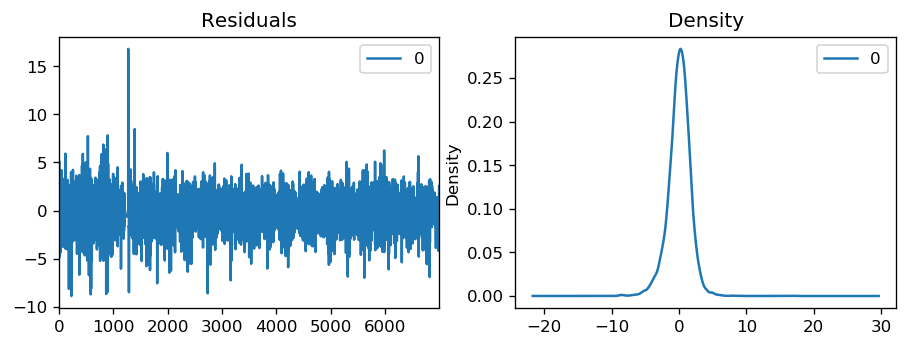

In [30]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde',title='Density', ax=ax[1])
plt.show()

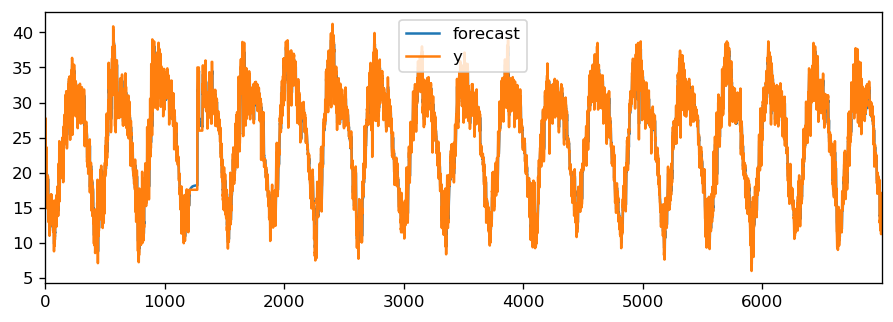

In [31]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

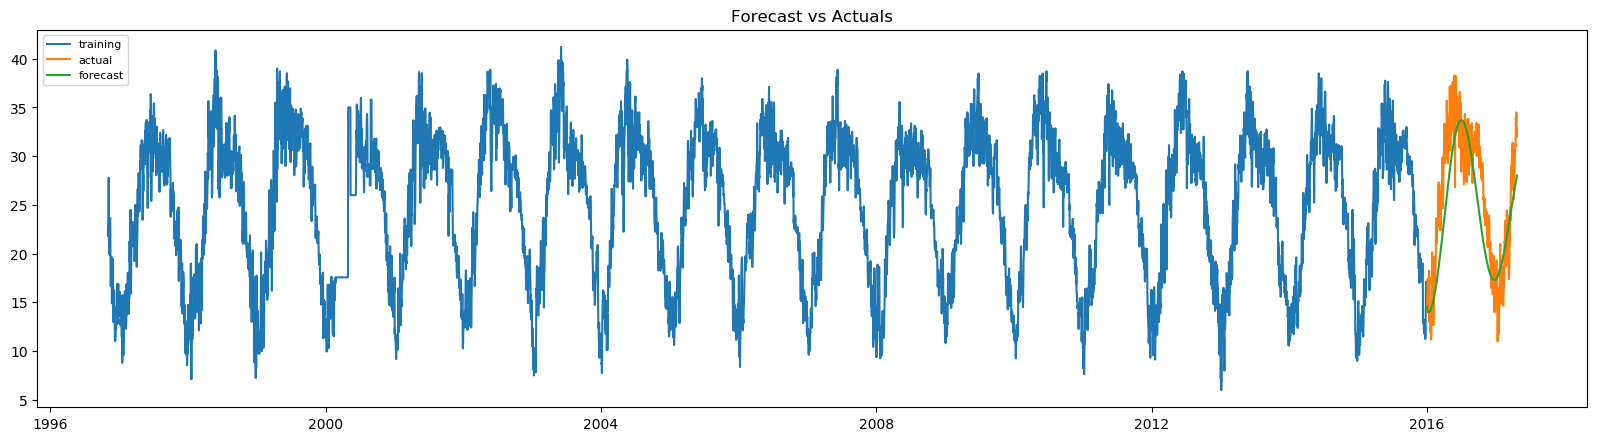

In [32]:
# # Forecast
fc, se, conf = model_fit.forecast(480, alpha=0.05)  # 95% conf

# print(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

# # Plot
plt.figure(figsize=(20,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# test_df.index

In [44]:
df = pd.DataFrame(fc_series, columns=['values'])

In [47]:
df.to_csv('ModelOutput.csv',header=True)